In [1]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers datasets accelerate evaluate

from google.colab import drive
drive.mount('/content/drive')

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import os

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Setup complete - Device: {device}")
print(f"   GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Setting up...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
Mounted at /content/drive
 Setup complete - Device: cuda
   GPU: Tesla T4


In [2]:
# LOAD AND PREPARE DATASET

print("Loading dataset...")

df = pd.read_csv('data/complete_dataset.csv')

print(f"Total samples: {len(df)}")
print(f"Human: {len(df[df['label']=='human'])}")
print(f"AI: {len(df[df['label']=='ai'])}")

df['label_numeric'] = (df['label'] == 'ai').astype(int)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_numeric']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df['label_numeric']
)

print(f"\nSplit:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")

Loading dataset...
Total samples: 1052
Human: 457
AI: 595

Split:
  Train: 756 samples
  Val:   85 samples
  Test:  211 samples


In [3]:
# CHOOSE MODEL AND LOAD TOKENIZER

print("Loading model and tokenizer...")

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"✅ Model: {model_name}")
print(f"   Tokenizer loaded")
print(f"   Max length: {tokenizer.model_max_length}")

Loading model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Model: distilbert-base-uncased
   Tokenizer loaded
   Max length: 512


In [4]:
# TOKENIZE DATASET

print("Tokenizing dataset...")

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )

train_dataset = Dataset.from_pandas(train_df[['text', 'label_numeric']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label_numeric']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label_numeric']])

train_dataset = train_dataset.rename_column('label_numeric', 'labels')
val_dataset = val_dataset.rename_column('label_numeric', 'labels')
test_dataset = test_dataset.rename_column('label_numeric', 'labels')

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f"✅ Tokenization complete")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val:   {len(val_dataset)} samples")
print(f"   Test:  {len(test_dataset)} samples")

Tokenizing dataset...


Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

✅ Tokenization complete
   Train: 756 samples
   Val:   85 samples
   Test:  211 samples


In [5]:
# LOAD PRE-TRAINED MODEL

print("Loading pre-trained model for fine-tuning...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "human", 1: "ai"},
    label2id={"human": 0, "ai": 1}
)

model.to(device)

print(f" Model loaded on {device}")
print(f"   Parameters: {model.num_parameters():,}")

Loading pre-trained model for fine-tuning...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded on cuda
   Parameters: 66,955,010


In [6]:
# DEFINE TRAINING ARGUMENTS

print("Setting up training configuration...")

output_dir = './models/classifier_checkpoints'

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    fp16=True,
    report_to="none",
)

print(" Training configuration:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Mixed precision (fp16): {training_args.fp16}")

Setting up training configuration...
 Training configuration:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Mixed precision (fp16): True


In [7]:
# DEFINE METRICS FUNCTION

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print(" Metrics function defined")

 Metrics function defined


In [8]:
# INITIALIZE TRAINER AND TRAIN MODEL

print("Initializing trainer...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(" Trainer initialized")
print("\nStarting training...")

train_result = trainer.train()

print("Training complete!")
print(f"   Train loss: {train_result.training_loss:.4f}")



Initializing trainer...
 Trainer initialized

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.129348,0.988235,0.989474,1.000000,0.979167
2,0.384300,0.027050,0.988235,0.989474,1.000000,0.979167
3,0.059700,0.016060,1.000000,1.000000,1.000000,1.000000


Training complete!
   Train loss: 0.1596


In [9]:
# EVALUATE ON VALIDATION SET

print("Evaluating on validation set...")

val_results = trainer.evaluate(val_dataset)

print("\nValidation Results:")
print(f"  Loss:      {val_results['eval_loss']:.4f}")
print(f"  Accuracy:  {val_results['eval_accuracy']:.1%}")
print(f"  Precision: {val_results['eval_precision']:.1%}")
print(f"  Recall:    {val_results['eval_recall']:.1%}")
print(f"  F1 Score:  {val_results['eval_f1']:.3f}")

Evaluating on validation set...



Validation Results:
  Loss:      0.0161
  Accuracy:  100.0%
  Precision: 100.0%
  Recall:    100.0%
  F1 Score:  1.000


In [10]:
# EVALUATE ON TEST SET

print("Evaluating on test set...")

predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

test_metrics = compute_metrics((predictions_output.predictions, labels))

print("\n")
print("TEST SET RESULTS")
print(f"  Accuracy:  {test_metrics['accuracy']:.1%}")
print(f"  Precision: {test_metrics['precision']:.1%}")
print(f"  Recall:    {test_metrics['recall']:.1%}")
print(f"  F1 Score:  {test_metrics['f1']:.3f}")


cm = confusion_matrix(labels, predictions)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")

Evaluating on test set...




TEST SET RESULTS
  Accuracy:  99.5%
  Precision: 100.0%
  Recall:    99.2%
  F1 Score:  0.996

Confusion Matrix:
  True Negatives:  92
  False Positives: 0
  False Negatives: 1
  True Positives:  118


Generating ROC curve...


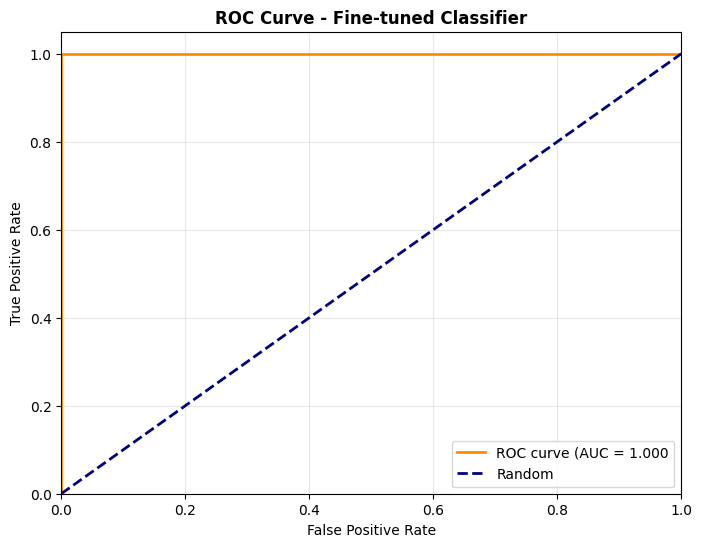

 AUC Score: 1.000


In [11]:
# ROC CURVE AND AUC

print("Generating ROC curve...")

y_scores = predictions_output.predictions[:, 1]

fpr, tpr, thresholds = roc_curve(labels, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fine-tuned Classifier', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('results/roc_curve_classifier.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" AUC Score: {roc_auc:.3f}")

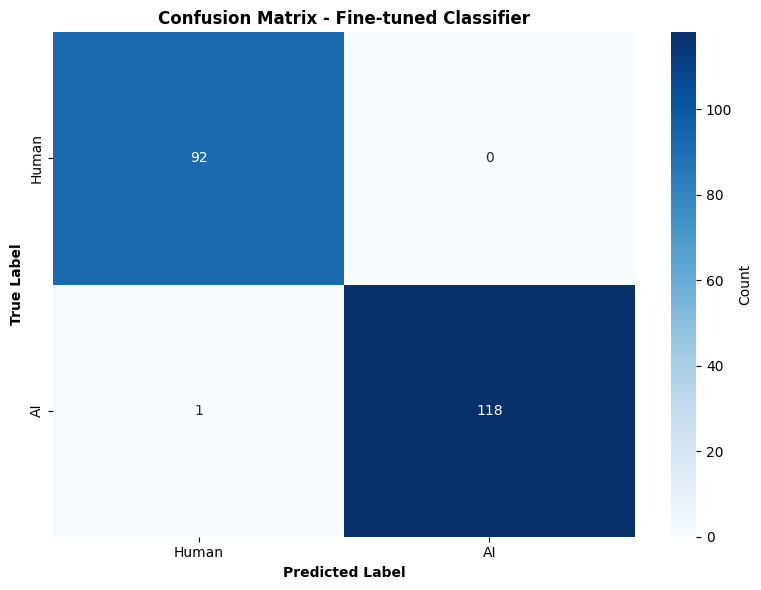

 Confusion matrix saved


In [12]:
# CONFUSION MATRIX VISUALIZATION

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title('Confusion Matrix - Fine-tuned Classifier', fontweight='bold')

plt.tight_layout()
plt.savefig('results/confusion_matrix_classifier.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved")

In [13]:
# SAVE MODEL AND RESULTS

print("Saving model and results...")

model_save_path = 'models/classifier_final'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f" Model saved to: {model_save_path}")

results_summary = {
    'method': 'Fine-tuned Classifier',
    'model': model_name,
    'accuracy': test_metrics['accuracy'],
    'precision': test_metrics['precision'],
    'recall': test_metrics['recall'],
    'f1': test_metrics['f1'],
    'auc': roc_auc,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'epochs': training_args.num_train_epochs,
}

import json
with open('results/classifier_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

test_results_df = pd.DataFrame({
    'true_label': labels,
    'predicted_label': predictions,
    'confidence_human': predictions_output.predictions[:, 0],
    'confidence_ai': predictions_output.predictions[:, 1],
})

test_results_df.to_csv('results/classifier_test_predictions.csv', index=False)

print(" Results saved")
print("CLASSIFIER DETECTOR SUMMARY")
print(f"Model: {model_name}")
print(f"Accuracy:  {test_metrics['accuracy']:.1%}")
print(f"Precision: {test_metrics['precision']:.1%}")
print(f"Recall:    {test_metrics['recall']:.1%}")
print(f"F1 Score:  {test_metrics['f1']:.3f}")
print(f"AUC:       {roc_auc:.3f}")

Saving model and results...
 Model saved to: models/classifier_final
 Results saved
CLASSIFIER DETECTOR SUMMARY
Model: distilbert-base-uncased
Accuracy:  99.5%
Precision: 100.0%
Recall:    99.2%
F1 Score:  0.996
AUC:       1.000


Loading results from all methods...

COMPARISON OF ALL METHODS
     Method  Accuracy  Precision   Recall       F1      AUC
 Perplexity  0.791469   0.786260 0.865546 0.824000 0.871118
Statistical  0.938389   0.964912 0.924370 0.944206 0.983102
 Classifier  0.995261   1.000000 0.991597 0.995781 1.000000


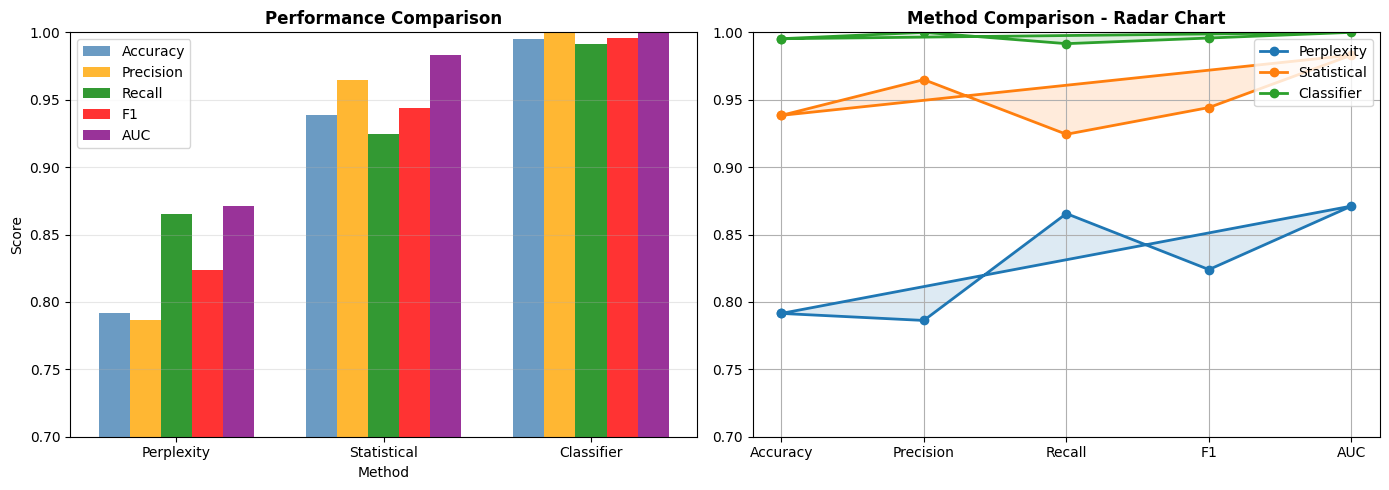


Comparison visualization saved

Key Insights:
  Best overall: Classifier (F1 = 0.996)
  Improvement from Perplexity to Classifier: 0.172


In [14]:
# COMPARE ALL THREE METHODS

print("Loading results from all methods...\n")

with open('results/perplexity_detector_results.json', 'r') as f:
    perplexity_results = json.load(f)

with open('results/statistical_detector_results.json', 'r') as f:
    statistical_results = json.load(f)

with open('results/classifier_results.json', 'r') as f:
    classifier_results = json.load(f)

comparison_df = pd.DataFrame({
    'Method': ['Perplexity', 'Statistical', 'Classifier'],
    'Accuracy': [
        perplexity_results['accuracy'],
        statistical_results['accuracy'],
        classifier_results['accuracy']
    ],
    'Precision': [
        perplexity_results['precision'],
        statistical_results['precision'],
        classifier_results['precision']
    ],
    'Recall': [
        perplexity_results['recall'],
        statistical_results['recall'],
        classifier_results['recall']
    ],
    'F1': [
        perplexity_results['f1'],
        statistical_results['f1'],
        classifier_results['f1']
    ],
    'AUC': [
        perplexity_results['auc'],
        statistical_results['auc'],
        classifier_results['auc']
    ]
})

print("COMPARISON OF ALL METHODS")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart of metrics
ax1 = axes[0]
x = np.arange(len(comparison_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
colors = ['steelblue', 'orange', 'green', 'red', 'purple']

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i], alpha=0.8)

ax1.set_xlabel('Method')
ax1.set_ylabel('Score')
ax1.set_title('Performance Comparison', fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(comparison_df['Method'])
ax1.legend()
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylim([0.7, 1.0])

# Plot 2: Radar chart
ax2 = axes[1]
categories = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for idx, method in enumerate(comparison_df['Method']):
    values = comparison_df.iloc[idx][categories].values.flatten().tolist()
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=method)
    ax2.fill(angles, values, alpha=0.15)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0.7, 1.0)
ax2.set_title('Method Comparison - Radar Chart', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.savefig('results/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison visualization saved")

print("\nKey Insights:")
best_method = comparison_df.loc[comparison_df['F1'].idxmax(), 'Method']
print(f"  Best overall: {best_method} (F1 = {comparison_df['F1'].max():.3f})")
print(f"  Improvement from Perplexity to {best_method}: {(comparison_df['F1'].max() - comparison_df['F1'].min()):.3f}")